In [1]:
from collections import Counter
import os

from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from easydict import EasyDict as edict
from imutils.paths import list_images
from matplotlib import pyplot as plt
from torchvision import transforms
import torch.nn.functional as F
from sklearn.metrics import *
from tqdm.auto import tqdm
from torch import optim
import seaborn as sns
from torch import nn
import numpy as np
import torch
import timm
import cv2

/root/anaconda3/envs/torch_1.x/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
SEP       = os.path.sep
ROOT_PATH = SEP.join(os.getcwd().split(SEP)[:-4])
DATA_PATH = f'{ROOT_PATH}/Datasets/Cats'

In [3]:
args           = edict({})
args.bs        = 64
args.lr        = 5e-4
args.seed      = 99
args.device    = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
args.epochs    = 20
args.n_samples = 3

In [4]:
class CatsDataset(Dataset):

    def __init__(self, paths, dtype = 'train'):

        self.paths     = paths
        self.dtype     = dtype
        
        self.transform          = {}
        self.transform['train'] = transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.Resize((312, 312)),
                                        transforms.CenterCrop(299),
                                        transforms.ToTensor()
                                    ])

        self.transform['test']  = transforms.Compose([
                                    transforms.ToPILImage(),
                                    transforms.Resize((312, 312)),
                                    transforms.CenterCrop(299),
                                    transforms.ToTensor()
                                ])

    
    def show_distribution(self):

        labels = [path.split(SEP)[-2] for path in self.paths]
        lb_cnt = Counter(labels)

        plt.bar(lb_cnt.keys(), lb_cnt.values())
        for k, v in lb_cnt.items():

            plt.text(k, v, v,
                     ha = 'center', va = 'bottom')
    

    def show_samples(self, n_samples = args.n_samples):

        random_idx  = np.random.randint(0, len(self.paths), n_samples)
        _, axes     = plt.subplots(1, n_samples, figsize = ((7 * n_samples) + 3, 7))

        for ax, idx in zip(axes, random_idx):

            image   = self.imread(self.paths[idx])

            if self.transform:
                image = self.transform[self.dtype](image)
                
            label   = get_label(self.paths[idx])

            ax.imshow(np.transpose(to_numpy(image), (1, 2, 0)))
            ax.set_title(label)
            ax.axis(False)


    def imread(self, path, chn = 3):

        image = cv2.imread(path)
        flag  = cv2.COLOR_BGR2RGB if chn == 3 else cv2.COLOR_BGR2GRAY

        return cv2.cvtColor(image, flag)
        
    
    
    def __len__(self):

        return len(self.paths)


    def __getitem__(self, idx):

        image = cv2.imread(self.paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = get_label(self.paths[idx])

        if self.transform:
            image = self.transform[self.dtype](image)

        label = torch.tensor(lb2idx[label])

        return image, label


class BleedNet(nn.Module):

    def __init__(self, n_classes):

        super(BleedNet, self).__init__()
        self.n_classes = n_classes

        self.base_model    = timm.create_model('resnet152d', pretrained = True)
        self.base_model.fc = nn.Sequential(
                                nn.Linear(self.base_model.fc.in_features, 512),
                                nn.Dropout(0.4),
                                nn.ReLU(),

                                nn.Linear(512, 128),
                                nn.Dropout(0.4),
                                nn.ReLU(),

                                nn.Linear(128, 32),
                                nn.Dropout(0.3),
                                nn.ReLU(),

                                nn.Linear(32, n_classes)
                            )


    def forward(self, x):

        x    = self.base_model(x)
        return x



def train(model, loader, optim):

    preds, gt, losses = [], [], []
    model.train()

    for image, label in (pbar := tqdm(loader)):

        pbar.set_description('[TRAIN]   ')
        optimizer.zero_grad()
        
        image   = image.to(args.device)
        label   = label.to(args.device)

        outputs = model(image)
        loss    = loss_func(outputs, label)
        pred    = outputs.max(1, keepdim = True)[1]
        
        loss.backward()
        optimizer.step()

        preds.extend(to_numpy(pred))
        gt.extend(to_numpy(label))
        losses.append(loss.item())

    accuracy  = accuracy_score(gt, preds)
    losses    = sum(losses) / len(losses)

    return accuracy, losses


def evaluate(model, loader):

    preds, gt, losses = [], [], []
    
    model.eval()
    with torch.no_grad():
        for image, label in (pbar := tqdm(loader)):

            pbar.set_description('[EVALUATE]')
            image = image.to(args.device)
            label = label.to(args.device)

            outputs = model(image)
            loss    = loss_func(outputs, label)
            pred    = outputs.max(1, keepdim = True)[1]

            preds.extend(to_numpy(pred))
            gt.extend(to_numpy(label))
            losses.append(loss.item())

    accuracy  = accuracy_score(gt, preds)
    losses    = sum(losses) / len(losses)

    return accuracy, losses

get_label = lambda   path: path.split(SEP)[-2]
to_numpy  = lambda tensor: tensor.detach().cpu().numpy()

In [5]:
image_paths               = sorted(list_images(DATA_PATH))
labels                    = [get_label(path) for path in image_paths]

lb2idx                    = {lb  : idx for idx,  lb in enumerate(set(labels))}
idx2lb                    = {idx : lb  for lb , idx in lb2idx.items()}

train_paths, valid_paths  = train_test_split(image_paths   , test_size    =        0.2, stratify = labels,
                                             shuffle = True, random_state =  args.seed)
train_paths, test_paths   = train_test_split(train_paths   , test_size    =       0.25, stratify = [get_label(path) for path in train_paths],
                                             shuffle = True, random_state =  args.seed)

In [6]:
train_dataset = CatsDataset(train_paths)
test_dataset  = CatsDataset(test_paths   , dtype = 'test')
valid_dataset = CatsDataset(valid_paths  , dtype = 'test')

train_loader  = DataLoader(train_dataset, shuffle = True , batch_size = args.bs)
test_loader   = DataLoader(test_dataset , shuffle = False, batch_size = args.bs)
valid_loader  = DataLoader(valid_dataset, shuffle = False, batch_size = 1)

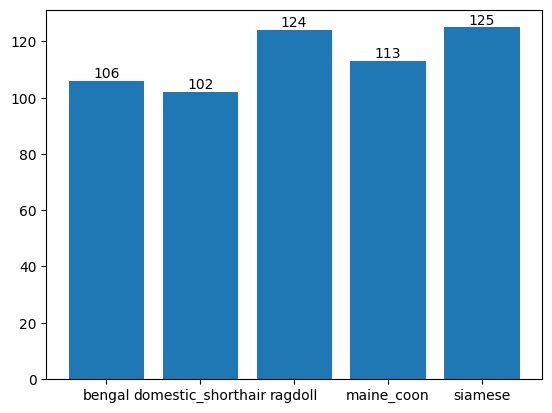

In [7]:
train_dataset.show_distribution()

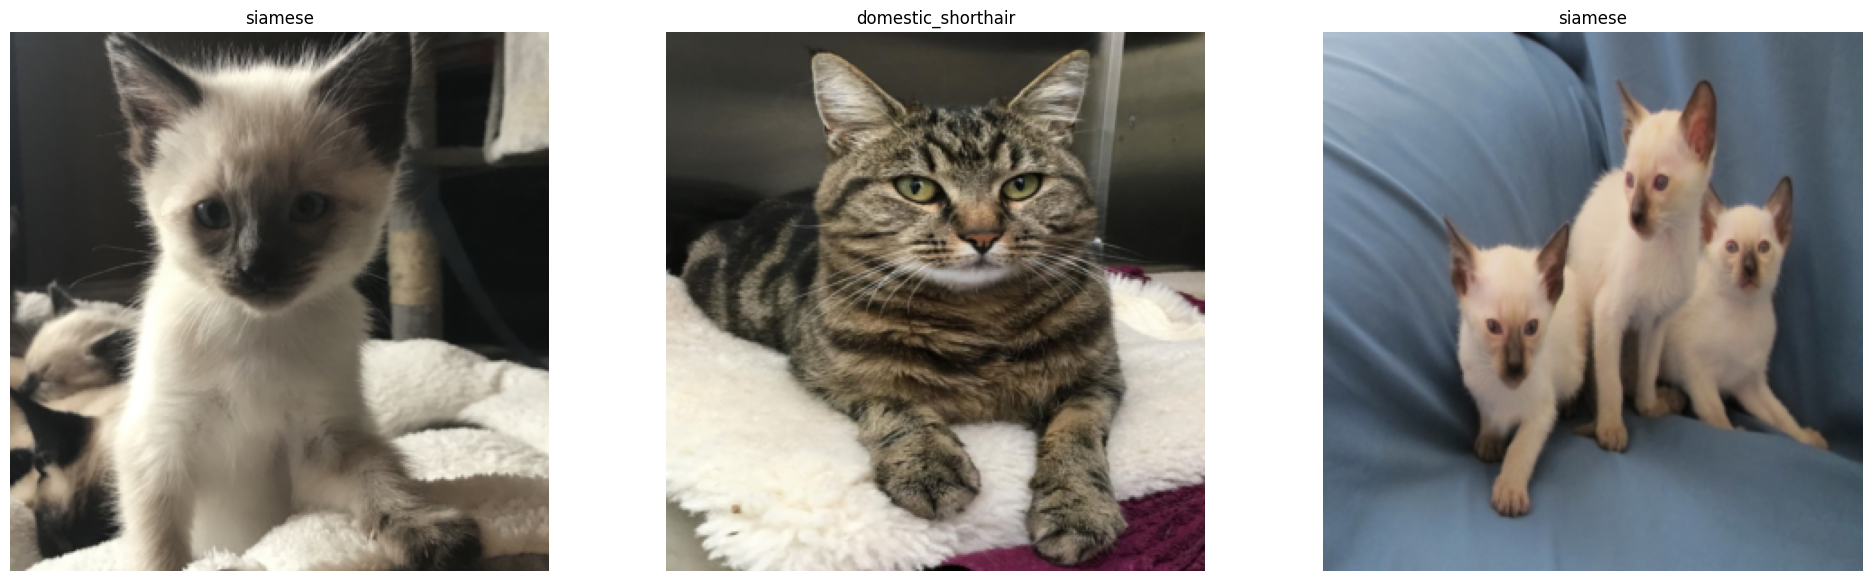

In [8]:
train_dataset.show_samples()

In [9]:
model     = BleedNet(len(idx2lb)).to(args.device)
optimizer = optim.Adam(model.parameters(), lr = args.lr)
loss_func = nn.CrossEntropyLoss()

In [10]:
for epoch in range(1, args.epochs + 1):

    print(f'[{epoch} / {args.epochs}]')
    tr_acc, tr_loss = train(model   , train_loader, optimizer)
    te_acc, te_loss = evaluate(model,  test_loader)

    print(f'[TRAIN] accuracy : {tr_acc * 100:.3f} %, loss : {tr_loss:.3f}')
    print(f'[TEST]  accuracy : {te_acc * 100:.3f} %, loss : {te_loss:.3f}\n')

[1 / 20]


[EVALUATE]: 100%|██████████| 3/3 [00:17<00:00,  5.79s/it]


[TRAIN] accuracy : 28.421 %, loss : 1.565
[TEST]  accuracy : 49.474 %, loss : 1.396

[2 / 20]


[EVALUATE]: 100%|██████████| 3/3 [00:18<00:00,  6.05s/it]


[TRAIN] accuracy : 50.702 %, loss : 1.252
[TEST]  accuracy : 77.895 %, loss : 0.956

[3 / 20]


[EVALUATE]: 100%|██████████| 3/3 [00:17<00:00,  5.80s/it]


[TRAIN] accuracy : 76.316 %, loss : 0.768
[TEST]  accuracy : 72.632 %, loss : 1.019

[4 / 20]


[EVALUATE]: 100%|██████████| 3/3 [00:17<00:00,  5.78s/it]


[TRAIN] accuracy : 85.088 %, loss : 0.506
[TEST]  accuracy : 79.474 %, loss : 1.321

[5 / 20]


[EVALUATE]: 100%|██████████| 3/3 [00:19<00:00,  6.40s/it]


[TRAIN] accuracy : 91.228 %, loss : 0.326
[TEST]  accuracy : 77.368 %, loss : 1.355

[6 / 20]


[EVALUATE]: 100%|██████████| 3/3 [00:18<00:00,  6.23s/it]


[TRAIN] accuracy : 95.263 %, loss : 0.209
[TEST]  accuracy : 84.737 %, loss : 0.943

[7 / 20]


[EVALUATE]: 100%|██████████| 3/3 [00:18<00:00,  6.19s/it]


[TRAIN] accuracy : 94.912 %, loss : 0.193
[TEST]  accuracy : 85.263 %, loss : 0.740

[8 / 20]


[EVALUATE]: 100%|██████████| 3/3 [00:18<00:00,  6.11s/it]


[TRAIN] accuracy : 95.965 %, loss : 0.149
[TEST]  accuracy : 82.105 %, loss : 0.803

[9 / 20]


[EVALUATE]: 100%|██████████| 3/3 [00:18<00:00,  6.18s/it]


[TRAIN] accuracy : 98.246 %, loss : 0.098
[TEST]  accuracy : 85.789 %, loss : 0.587

[10 / 20]


[EVALUATE]: 100%|██████████| 3/3 [00:18<00:00,  6.30s/it]


[TRAIN] accuracy : 97.895 %, loss : 0.083
[TEST]  accuracy : 86.316 %, loss : 0.845

[11 / 20]


[EVALUATE]: 100%|██████████| 3/3 [00:17<00:00,  5.93s/it]


[TRAIN] accuracy : 98.421 %, loss : 0.104
[TEST]  accuracy : 83.158 %, loss : 1.037

[12 / 20]


[EVALUATE]: 100%|██████████| 3/3 [00:18<00:00,  6.14s/it]


[TRAIN] accuracy : 96.316 %, loss : 0.196
[TEST]  accuracy : 84.211 %, loss : 0.929

[13 / 20]


[EVALUATE]: 100%|██████████| 3/3 [00:18<00:00,  6.15s/it]


[TRAIN] accuracy : 95.263 %, loss : 0.190
[TEST]  accuracy : 86.842 %, loss : 0.605

[14 / 20]


[EVALUATE]: 100%|██████████| 3/3 [00:18<00:00,  6.26s/it]


[TRAIN] accuracy : 97.193 %, loss : 0.117
[TEST]  accuracy : 88.421 %, loss : 0.530

[15 / 20]


[EVALUATE]: 100%|██████████| 3/3 [00:18<00:00,  6.03s/it]


[TRAIN] accuracy : 97.895 %, loss : 0.070
[TEST]  accuracy : 86.842 %, loss : 0.592

[16 / 20]


[EVALUATE]: 100%|██████████| 3/3 [00:19<00:00,  6.66s/it]


[TRAIN] accuracy : 98.947 %, loss : 0.048
[TEST]  accuracy : 87.368 %, loss : 0.650

[18 / 20]


[EVALUATE]: 100%|██████████| 3/3 [00:17<00:00,  5.99s/it]


[TRAIN] accuracy : 98.772 %, loss : 0.064
[TEST]  accuracy : 82.105 %, loss : 0.887

[19 / 20]


[EVALUATE]: 100%|██████████| 3/3 [00:17<00:00,  5.84s/it]


[TRAIN] accuracy : 97.895 %, loss : 0.134
[TEST]  accuracy : 81.579 %, loss : 1.176

[20 / 20]


[EVALUATE]: 100%|██████████| 3/3 [00:17<00:00,  5.96s/it]

[TRAIN] accuracy : 96.842 %, loss : 0.098
[TEST]  accuracy : 79.474 %, loss : 1.383



In [11]:
model.eval()

preds, gt     = [], []
with torch.no_grad():
    for image, label in tqdm(valid_loader):
    
        image = image.to(args.device)
        label = label.to(args.device)

        output = model(image)
        pred   = output.max(1, keepdim = True)[1]

        preds.extend(pred.detach().cpu().numpy()[0])
        gt.extend(label.detach().cpu().numpy())

print(classification_report(gt, preds))

100%|██████████| 191/191 [00:21<00:00,  8.69it/s]

              precision    recall  f1-score   support

           0       0.83      0.86      0.85        35
           1       0.74      0.69      0.72        42
           2       0.85      0.50      0.63        34
           3       0.54      0.86      0.66        42
           4       0.83      0.63      0.72        38

    accuracy                           0.71       191
   macro avg       0.76      0.71      0.71       191
weighted avg       0.75      0.71      0.71       191

